# ##서울시 미세먼지 발생원인 분석 및 예측##

 서울시 중구(시청)에서 측정된 미세먼지 양, 기상정보를 활용하여 
  미세먼지 발생에 영향을 주는 인자를 도출하고 선정된 영향인자를 활용한 미세먼지 발생량을 예측

   
[분석 절차]

1. 데이터 처리 : 데이터 변환, 현황(통계,분포,이상치/결측치 등) 확인 및 처리 방법 적용 
2. 탐색적 분석 : 그래프 분석 및 통계적 방법 활용하여 인자 탐색 및 특성 파악
3. 영향인자 분석 : 모델링 기법 활용하여 영향인자 탐색 및 특성 파악
   (선형회귀,나무/앙상블 모델(Tree, Random Forest,  Gradient Boosting 등)
   -.3 단계에서는 기법별 세밀한 파라미터 조정작업은 생략 가능함
4. 주요 영향인자 선정 : 2,3 분석 결과를 활용하여 예측 모델에 사용될 유의한 인자 선정 및 사유 기술
5. 예측 모델 개발 및 평가: 4에서 선정된 영향인자를 활용한 미세먼지 발생량 예측
   -.5 단계에서는 기법별로 주요 파라미터 조정작업 일부 적용 필요 
6. 업무 적용방안, 개선안 도출 
   예) 발생 예측 및 조기경보 등

In [313]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Scale 변환-> 설명변수 변환 : 회귀분석.설명변수 회귀계수 표준화
from sklearn.preprocessing import StandardScaler
# train, test 데이터 분할 함수
from sklearn.model_selection import train_test_split

# 회귀모델 
import statsmodels.formula.api as smf
import statsmodels.api as sm
# 선형회귀모형
from sklearn.linear_model import LinearRegression

# 다중공선성 확인
from statsmodels.stats.outliers_influence import variance_inflation_factor
# 변수 선택법(후진제거법)
from sklearn.feature_selection import RFE

# 평가 함수
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error


### 옵션 지정

In [72]:
# 데이터 소수점 지정
pd.options.display.precision = 2

# 한글 폰트(맑은 고딕) 적용
matplotlib.rc("font", family="Malgun Gothic")

## @1.데이터 처리

In [141]:
df_raw0 = pd.read_csv("D:/WORK/DATA/AIR_POLLUTION.CSV", parse_dates = ["MeasDate"])
print("shape: ", df_raw.shape)

df_raw0.head()

shape:  (366, 14)


,MeasDate,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,SNOW,CLOUD
0,2019-07-01,29.0,0.05,0.02,0.5,3.00e-03,24.03,0.0,2.30,249,63.2,995.1,0.0,5.70
1,2019-07-02,26.0,0.05,0.02,0.5,3.00e-03,24.29,0.0,2.26,265,63.2,998.6,0.0,3.83
2,2019-07-03,30.0,0.04,0.02,0.4,3.00e-03,24.18,0.0,1.79,280,65.3,998.3,0.0,6.29
3,2019-07-04,28.0,0.03,0.03,0.4,3.00e-03,25.35,0.0,2.04,263,58.6,996.6,0.0,2.54
4,2019-07-05,29.0,0.04,0.04,0.5,3.00e-03,27.30,0.0,1.45,175,45.5,993.5,0.0,3.92


In [142]:
# 데이터 구조 확인
df_raw0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   MeasDate   366 non-null    datetime64[ns]
 1   PM10       365 non-null    float64       
 2   O3         365 non-null    float64       
 3   NO2        365 non-null    float64       
 4   CO         311 non-null    float64       
 5   SO2        365 non-null    float64       
 6   TEMP       366 non-null    float64       
 7   RAIN       366 non-null    float64       
 8   WIND       366 non-null    float64       
 9   WIND_DIR   366 non-null    int64         
 10  HUMIDITY   366 non-null    float64       
 11  ATM_PRESS  366 non-null    float64       
 12  SNOW       366 non-null    float64       
 13  CLOUD      366 non-null    float64       
dtypes: datetime64[ns](1), float64(12), int64(1)
memory usage: 40.2 KB


### 데이터 특성 확인 : 기초통계, 이상치/결측치 확인 등

In [143]:
# 기초 통계량
df_raw0.describe()

,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,SNOW,CLOUD
count,365.00,3.65e+02,3.65e+02,311.00,3.65e+02,366.00,366.00,366.00,366.00,366.00,366.00,366.00,366.00
mean,33.42,2.36e-02,2.68e-02,0.52,3.03e-03,13.86,0.38,2.23,209.45,60.30,1005.85,0.02,5.06
std,15.94,1.19e-02,1.03e-02,0.15,6.32e-04,9.83,1.12,0.72,70.74,14.53,8.13,0.22,2.99
min,5.00,2.00e-03,8.00e-03,0.30,2.00e-03,-7.95,0.00,0.94,50.00,17.90,983.80,0.00,0.00
25%,22.00,1.40e-02,1.90e-02,0.40,3.00e-03,5.49,0.00,1.72,160.25,49.65,999.40,0.00,2.51
50%,31.00,2.30e-02,2.50e-02,0.50,3.00e-03,14.00,0.00,2.09,221.00,61.05,1006.45,0.00,5.31
75%,42.00,3.20e-02,3.40e-02,0.60,3.00e-03,23.07,0.11,2.62,266.00,69.95,1011.58,0.00,7.57
max,101.00,6.20e-02,5.90e-02,1.00,5.00e-03,31.72,11.80,5.88,351.00,95.00,1025.50,3.20,10.00


In [144]:
# 데이터 품질:이상치, 결측치

# 결측치(True) 현황 요약 :sum 함수
df_raw0.isnull().sum()

MeasDate      0
PM10          1
O3            1
NO2           1
CO           55
SO2           1
TEMP          0
RAIN          0
WIND          0
WIND_DIR      0
HUMIDITY      0
ATM_PRESS     0
SNOW          0
CLOUD         0
dtype: int64

### => 결측치 처리 필요

    PM10 (2020-05-24) : 목표변수로 적절한 결측값 확인 불가하므로 삭제
    CO : 목표변수에 대한 영향도 확인 후 처리 결정

In [145]:
df_raw = df_raw.dropna(subset=["PM10"])

df_raw.shape
# 목표변수 결측치 행 제거

(365, 14)

In [146]:
df_raw.isnull().sum()

MeasDate      0
PM10          0
O3            0
NO2           0
CO           54
SO2           0
TEMP          0
RAIN          0
WIND          0
WIND_DIR      0
HUMIDITY      0
ATM_PRESS     0
SNOW          0
CLOUD         0
dtype: int64

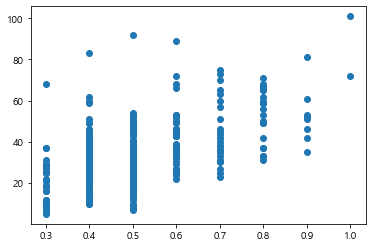

In [152]:
# 산점도로 PM10 vs. CO 관계 확인
plt.scatter(x="CO", y="PM10", data=df_raw)

In [150]:
# CO 결측치 처리 ??  CO 증가 -> PM10 증가  -> 단순히 평균/중앙값으로 대체하는 것은 위험하지만
# 숫자형 결측치 처리 :transform("집계함수")
# df_raw["CO"].fillna(df_raw["CO"].mean(), inplace=True)
df_raw.fillna(df_raw.median(), inplace=True)

print(df_raw.shape)
df_raw.isnull().sum()

(365, 14)


<ipython-input-150-a8ec56651242>:4: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df_raw.fillna(df_raw.median(), inplace=True)


MeasDate     0
PM10         0
O3           0
NO2          0
CO           0
SO2          0
TEMP         0
RAIN         0
WIND         0
WIND_DIR     0
HUMIDITY     0
ATM_PRESS    0
SNOW         0
CLOUD        0
dtype: int64

## @탐색적 분석

## 요약통계량

In [102]:
df_raw.describe()

,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,SNOW,CLOUD
count,366.00,3.66e+02,3.66e+02,366.00,3.66e+02,366.00,366.00,366.00,366.00,366.00,366.00,366.00,366.00
mean,33.42,2.36e-02,2.68e-02,0.51,3.03e-03,13.86,0.38,2.23,209.45,60.30,1005.85,0.02,5.06
std,15.92,1.19e-02,1.03e-02,0.14,6.32e-04,9.83,1.12,0.72,70.74,14.53,8.13,0.22,2.99
min,5.00,2.00e-03,8.00e-03,0.30,2.00e-03,-7.95,0.00,0.94,50.00,17.90,983.80,0.00,0.00
25%,22.00,1.42e-02,1.90e-02,0.40,3.00e-03,5.49,0.00,1.72,160.25,49.65,999.40,0.00,2.51
50%,31.00,2.30e-02,2.50e-02,0.50,3.00e-03,14.00,0.00,2.09,221.00,61.05,1006.45,0.00,5.31
75%,42.00,3.20e-02,3.38e-02,0.60,3.00e-03,23.07,0.11,2.62,266.00,69.95,1011.58,0.00,7.57
max,101.00,6.20e-02,5.90e-02,1.00,5.00e-03,31.72,11.80,5.88,351.00,95.00,1025.50,3.20,10.00


### => PM10(미세먼지 발생량) : 좌측으로 치우침 (평균 33.42 > 중앙값 31) ...

## 그래프 탐색

### Histogram

array([[<AxesSubplot:title={'center':'PM10'}>,
        <AxesSubplot:title={'center':'O3'}>,
        <AxesSubplot:title={'center':'NO2'}>,
        <AxesSubplot:title={'center':'CO'}>],
       [<AxesSubplot:title={'center':'SO2'}>,
        <AxesSubplot:title={'center':'TEMP'}>,
        <AxesSubplot:title={'center':'RAIN'}>,
        <AxesSubplot:title={'center':'WIND'}>],
       [<AxesSubplot:title={'center':'WIND_DIR'}>,
        <AxesSubplot:title={'center':'HUMIDITY'}>,
        <AxesSubplot:title={'center':'ATM_PRESS'}>,
        <AxesSubplot:title={'center':'SNOW'}>],
       [<AxesSubplot:title={'center':'CLOUD'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

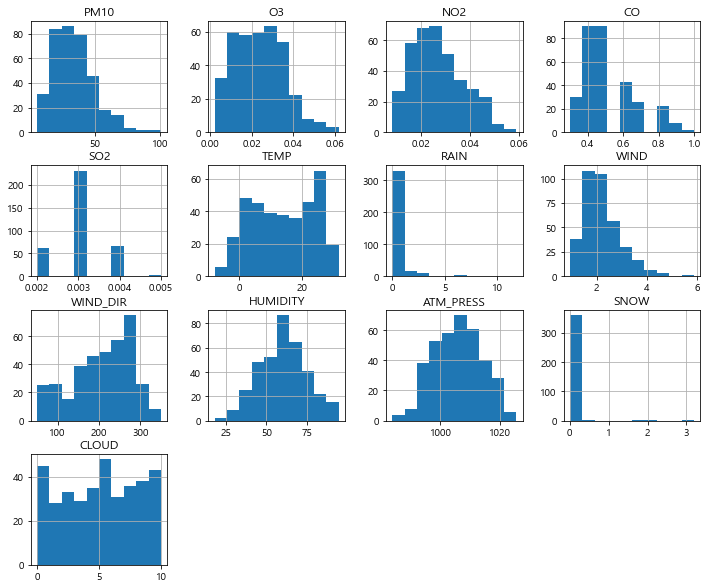

In [86]:
# hist(figsiz) : figsize = (x축 크기, y축 크기)-그래프 영역별 중첩 처리
df_raw.hist(figsize = (12,10))

### => 해석은...

### 상자 수염도표, Boxplot

<AxesSubplot:>

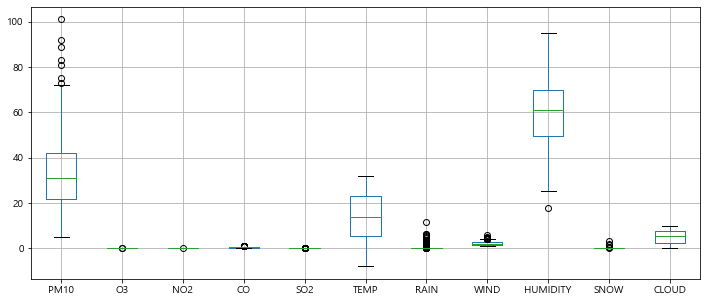

In [95]:
# boxplot: 상자수염도, figsize: 그래프 크기(x축, y축)
# df_raw.boxplot(figsize = (10, 4))

# df_raw_box = df_raw.drop(["MeasDate", "ATM_PRESS"], axis = 1, inplace = False)
df_raw_box = df_raw.drop(["MeasDate", "ATM_PRESS", "WIND_DIR"], axis = 1, inplace = False)
df_raw_box.boxplot(figsize = (12, 5))

### => PM10(미세먼지 발생량) : 이상치 포함 -> 어떻게 처리해야 하는가?

PM10            AxesSubplot(0.125,0.125;0.0503247x0.755)
O3            AxesSubplot(0.18539,0.125;0.0503247x0.755)
NO2          AxesSubplot(0.245779,0.125;0.0503247x0.755)
CO           AxesSubplot(0.306169,0.125;0.0503247x0.755)
SO2          AxesSubplot(0.366558,0.125;0.0503247x0.755)
TEMP         AxesSubplot(0.426948,0.125;0.0503247x0.755)
RAIN         AxesSubplot(0.487338,0.125;0.0503247x0.755)
WIND         AxesSubplot(0.547727,0.125;0.0503247x0.755)
WIND_DIR     AxesSubplot(0.608117,0.125;0.0503247x0.755)
HUMIDITY     AxesSubplot(0.668506,0.125;0.0503247x0.755)
ATM_PRESS    AxesSubplot(0.728896,0.125;0.0503247x0.755)
SNOW         AxesSubplot(0.789286,0.125;0.0503247x0.755)
CLOUD        AxesSubplot(0.849675,0.125;0.0503247x0.755)
dtype: object

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


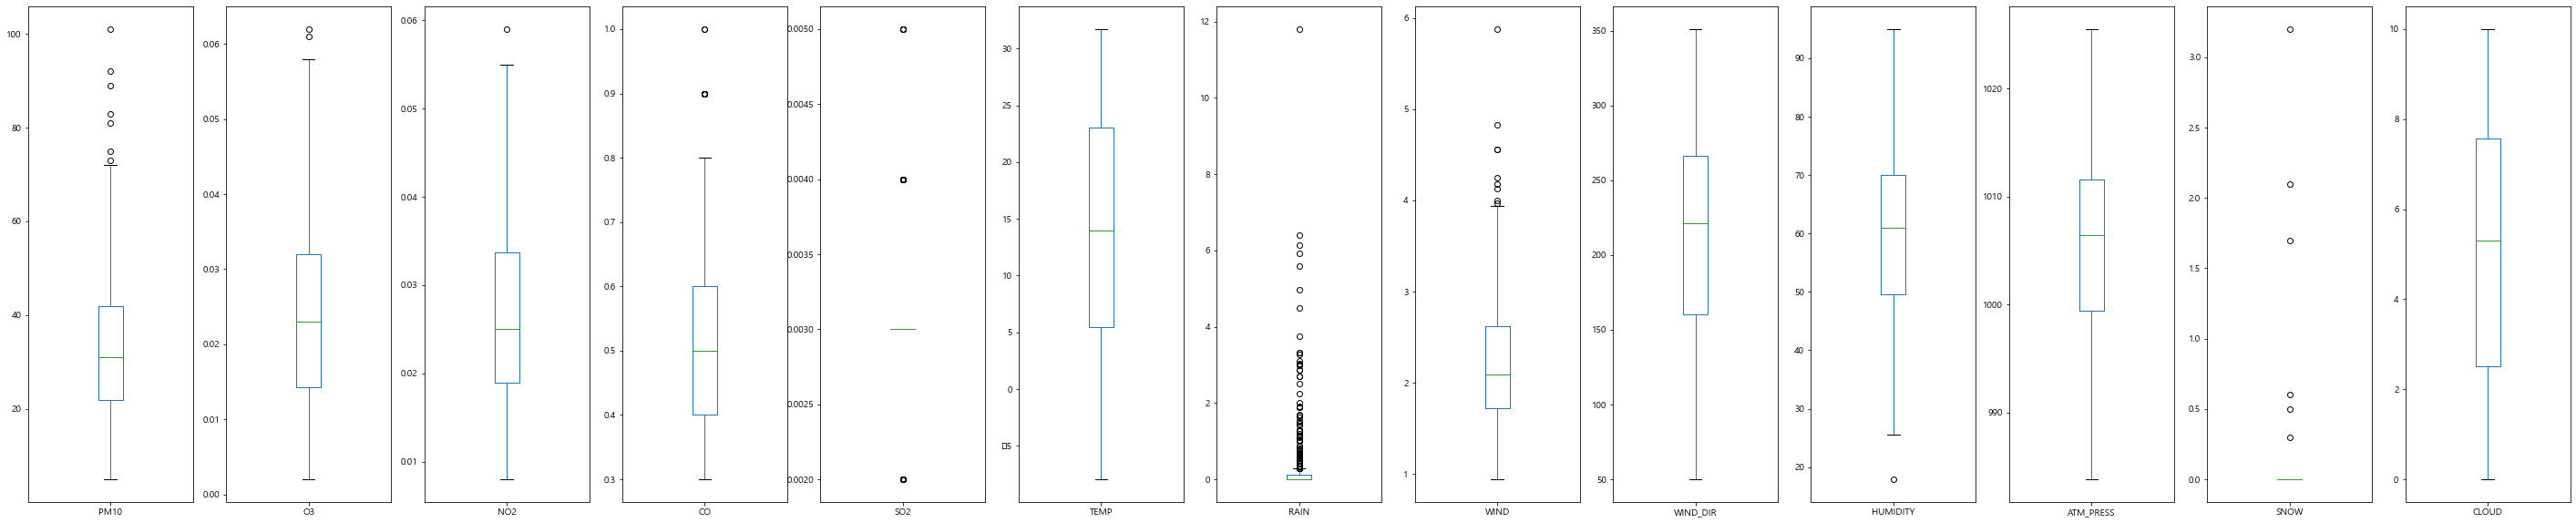

In [99]:
# 다른 방식 상자수염도표
df_raw.plot(kind = "box",
            figsize = (50,10), subplots = True, sharex = False, sharey = False)
#  잘 안보이네... 크기 조정 가능??

### 추세도표 : 산점도, 시계열도표

<AxesSubplot:xlabel='MeasDate', ylabel='PM10'>

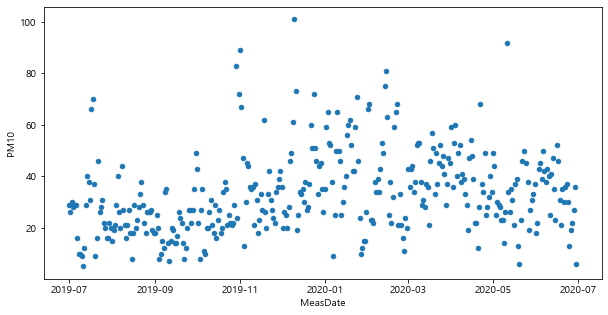

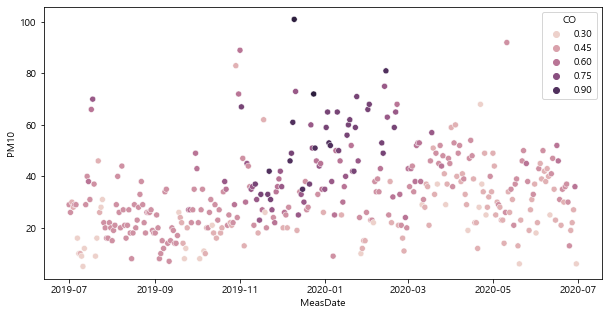

In [158]:
#산점도 
df_raw.plot.scatter(x="MeasDate", y = "PM10", figsize=(10,5) )

# Seaborn 사용
fig = plt.figure(figsize=(10,5)) # 크기 조정

# sns.scatterplot(x="MeasDate", y="PM10", data=df_raw)
sns.scatterplot(x = "MeasDate", y = "PM10", hue = "CO", data=df_raw )

<AxesSubplot:xlabel='MeasDate'>

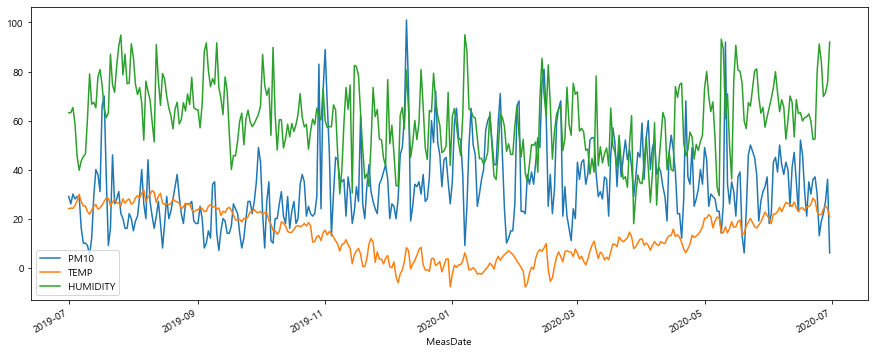

In [166]:
# 시계열도표
df_raw.plot.line(y=["PM10", "TEMP", "HUMIDITY"], x="MeasDate", figsize=(15,6))

### => PM10(미세먼지)는 온도가 낮은 겨울에 많이 발생하고...

### 산점도

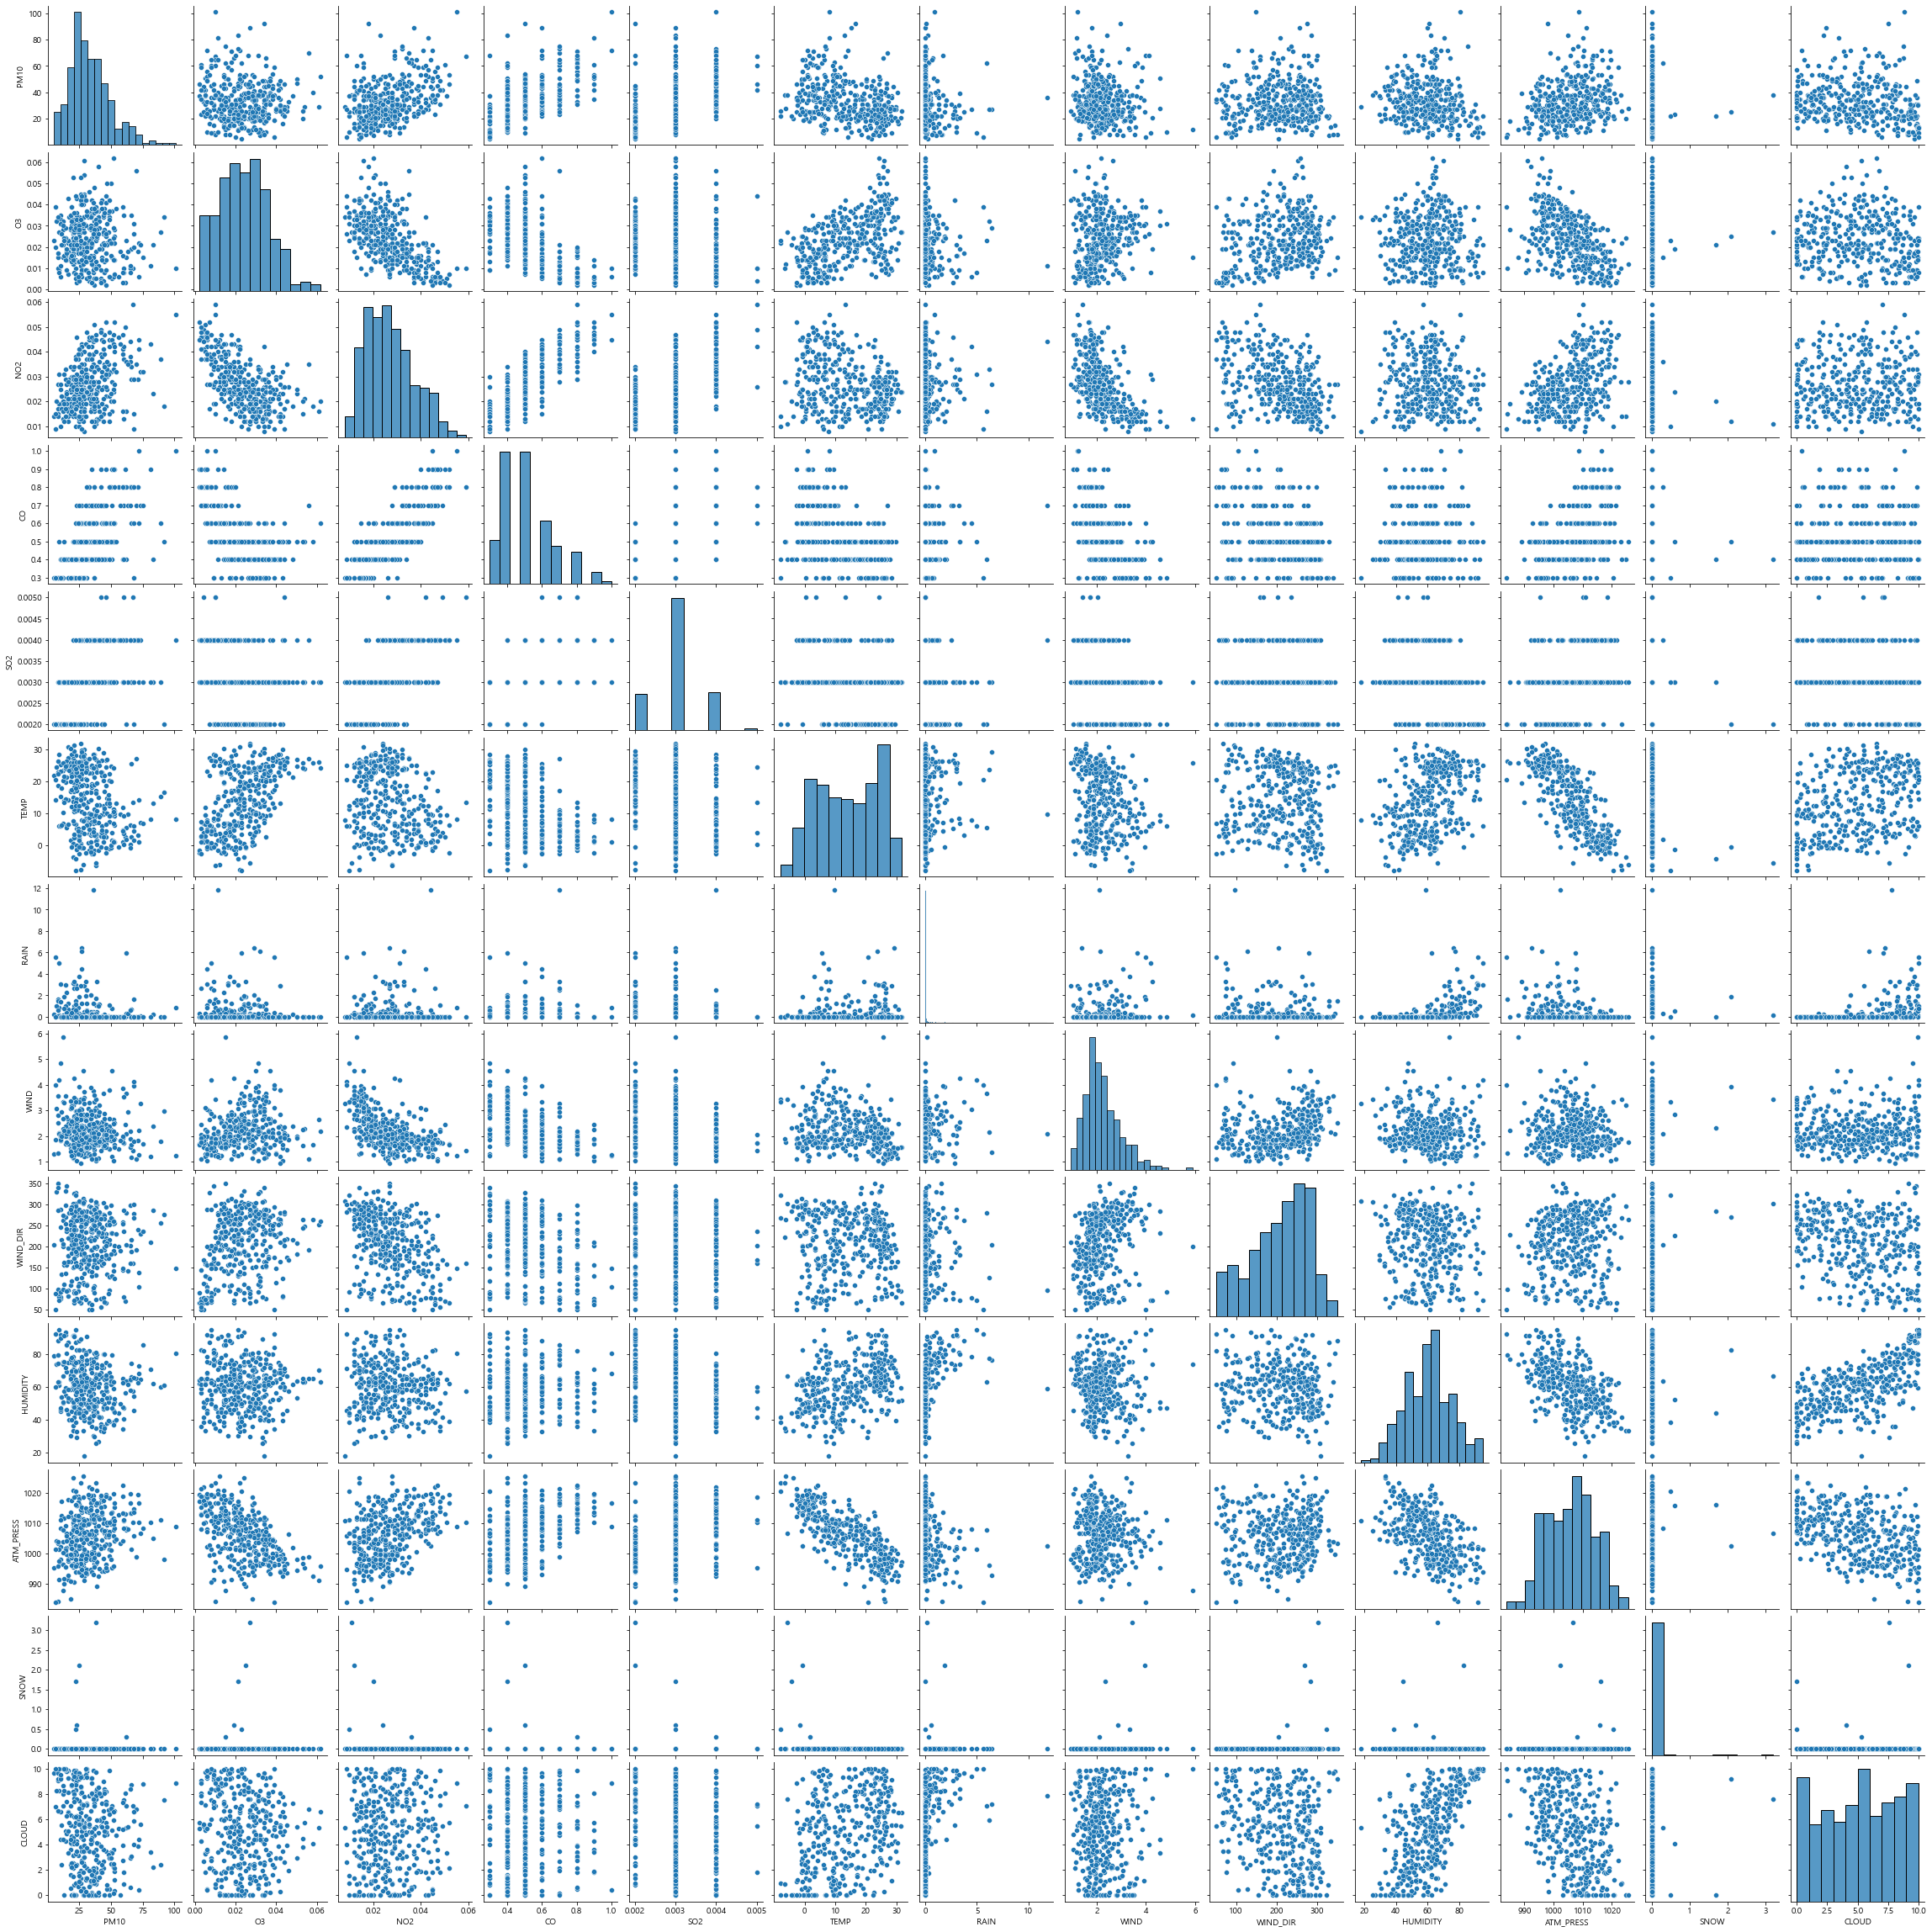

In [12]:
sns.pairplot(df_raw)

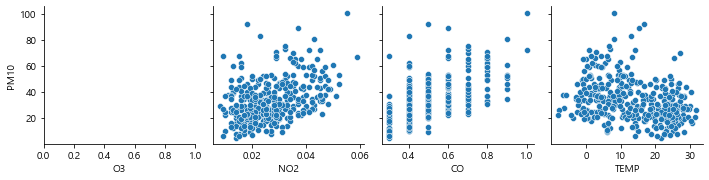

In [19]:
# sns.pairplot(data=df_raw, x_vars=["NO2", "CO"], y_vars="PM10")
sns.pairplot(data=df_raw, x_vars=["O3", "NO2", "CO", "TEMP"], y_vars="PM10")

#  첫번째 변수와의 산점도는 안 나옴!!!!!

### =>PM10(미세먼지)는 NO2, CO와 (+), 온도와는 (-) 관계

### 상관분석

In [11]:
df_corr = df_raw.corr()
df_corr

,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,SNOW,CLOUD
PM10,1.00,-5.18e-02,0.40,0.59,0.43,-0.31,-0.12,-0.10,0.02,-0.15,0.25,-2.00e-02,-0.17
O3,-0.05,1.00e+00,-0.59,-0.56,-0.23,0.52,-0.10,0.17,0.27,-0.04,-0.53,3.90e-03,-0.12
NO2,0.40,-5.92e-01,1.00,0.81,0.56,-0.24,0.03,-0.54,-0.41,-0.07,0.42,-1.21e-01,0.02
CO,0.59,-5.59e-01,0.81,1.00,0.59,-0.40,0.04,-0.46,-0.34,0.06,0.43,-5.63e-02,0.04
SO2,0.43,-2.34e-01,0.56,0.59,1.00,-0.27,-0.13,-0.25,-0.09,-0.30,0.33,-1.03e-01,-0.19
TEMP,-0.31,5.16e-01,-0.24,-0.40,-0.27,1.00,0.08,-0.21,-0.05,0.40,-0.79,-1.85e-01,0.34
RAIN,-0.12,-1.04e-01,0.03,0.04,-0.13,0.08,1.00,0.13,-0.18,0.40,-0.24,1.91e-02,0.36
WIND,-0.10,1.65e-01,-0.54,-0.46,-0.25,-0.21,0.13,1.00,0.24,-0.08,-0.06,1.45e-01,0.02
WIND_DIR,0.02,2.69e-01,-0.41,-0.34,-0.09,-0.05,-0.18,0.24,1.00,-0.10,0.07,1.08e-01,-0.29
HUMIDITY,-0.15,-3.77e-02,-0.07,0.06,-0.30,0.40,0.40,-0.08,-0.10,1.00,-0.51,2.11e-02,0.63


##### 목표변수(PM10)와 상관관계 높은 변수 (정렬)

In [20]:
abs(df_corr["PM10"]).sort_values(ascending = False)

PM10         1.00
CO           0.59
SO2          0.43
NO2          0.40
TEMP         0.31
ATM_PRESS    0.25
CLOUD        0.17
HUMIDITY     0.15
RAIN         0.12
WIND         0.10
O3           0.05
SNOW         0.02
WIND_DIR     0.02
Name: PM10, dtype: float64

#### 상관계수 히트맵

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


<AxesSubplot:>

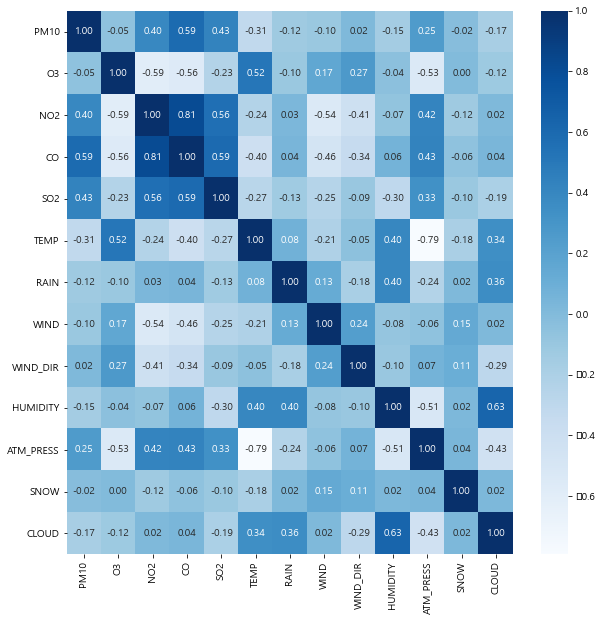

In [21]:
fig, ax = plt.subplots(figsize = (10,10))
sns.heatmap(df_corr, annot=True, fmt = ".2f", cmap = "Blues", ax = ax)

### => PM10(미세먼지)는 CO, SO2, NO2 와 (+)의 상관관계가  높고...

# @영향인자 분석 : 모델링 기법 활용

### 목적이 영향인자 탐색이므로 기법별 세밀한 파라미터 조정작업 생략 가능

## ==회귀분석

In [167]:
model_reg = smf.ols("PM10 ~ O3 + NO2 + CO + SO2 + TEMP + RAIN + WIND + WIND_DIR + HUMIDITY + ATM_PRESS + SNOW + CLOUD",
                           data = df_raw)
model_result = model_reg.fit()
print(model_result.summary())

                            OLS Regression Results                            
Dep. Variable:                   PM10   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.489
Method:                 Least Squares   F-statistic:                     29.99
Date:                Fri, 19 Feb 2021   Prob (F-statistic):           7.66e-47
Time:                        15:12:14   Log-Likelihood:                -1399.5
No. Observations:                 365   AIC:                             2825.
Df Residuals:                     352   BIC:                             2876.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    425.3786    161.638      2.632      0.0

### => 회귀계수 기준 O3, NO2,  CO, TEMP, WIND_DIR,... 유의

### 표준화 회귀계수 기준으로 변수 중요도 판단 : 설명변수 변환 적용

In [ ]:
# 목표변수, 설명변수 데이터 지정
df_raw_y = df_raw["PM10"]
df_raw_x = df_raw.drop(["PM10","MeasDate"], axis = 1, inplace = False)

print(df_raw_y.head())
print(df_raw_x.head())

In [64]:
# 설명변수 표준화
scaler = StandardScaler()
df_scale_x = scaler.fit_transform(df_raw_x)
df_scale_x = pd.DataFrame(df_scale, columns = df_raw_x.columns)
df_scale_x.head()

,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,SNOW,CLOUD
0,2.56,-0.57,-0.12,-0.05,1.04,-0.34,0.10,0.56,0.20,-1.32,-0.1,0.21
1,2.48,-0.67,-0.12,-0.05,1.06,-0.34,0.05,0.79,0.20,-0.89,-0.1,-0.41
2,1.55,-0.37,-0.83,-0.05,1.05,-0.34,-0.60,1.00,0.34,-0.93,-0.1,0.41
3,0.88,-0.08,-0.83,-0.05,1.17,-0.34,-0.26,0.76,-0.12,-1.14,-0.1,-0.85
4,1.80,0.80,-0.12,-0.05,1.37,-0.34,-1.07,-0.49,-1.02,-1.52,-0.1,-0.38


In [70]:
# 데이터 결합(Series + DataFrame) 
df_scale = pd.concat([df_raw_y, df_scale_x], axis=1)

df_scale.head()

,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,SNOW,CLOUD
0,29.0,2.56,-0.57,-0.12,-0.05,1.04,-0.34,0.10,0.56,0.20,-1.32,-0.1,0.21
1,26.0,2.48,-0.67,-0.12,-0.05,1.06,-0.34,0.05,0.79,0.20,-0.89,-0.1,-0.41
2,30.0,1.55,-0.37,-0.83,-0.05,1.05,-0.34,-0.60,1.00,0.34,-0.93,-0.1,0.41
3,28.0,0.88,-0.08,-0.83,-0.05,1.17,-0.34,-0.26,0.76,-0.12,-1.14,-0.1,-0.85
4,29.0,1.80,0.80,-0.12,-0.05,1.37,-0.34,-1.07,-0.49,-1.02,-1.52,-0.1,-0.38


<AxesSubplot:>

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


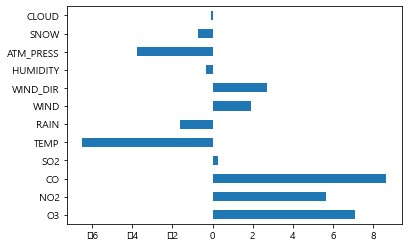

In [71]:
# 회귀분석:표준화된 설명변수 
model_reg_scale = smf.ols("PM10 ~ O3 + NO2 + CO + SO2 + TEMP + RAIN + WIND + WIND_DIR + HUMIDITY + ATM_PRESS + SNOW + CLOUD",
                           data = df_scale)
model_result_scale = model_reg_scale.fit()

# 회귀계수 그래프
model_result_scale.params.drop("Intercept").plot.barh()

### => 잠재적 유의인자 후보 
  
   (+) 방향 : CO, O3, NO2 
   
   (-) 방향 : TEMP, ATM_PRESS

## ==의사결정나무

### 유의인자 탐색 목적이므로 데이터 분할없이 실행 

In [36]:
# sklearn.tree 의 DecisionTreeRegressor: 예측의사결정나무
from sklearn.tree import DecisionTreeRegressor
# sklearn.tree의 export_graphviz: graphviz 패키지가 사용할 수 있는 .dot 확장자 파일로 저장
from sklearn.tree import export_graphviz
# graphviz import: 의사결정 나무 모델 시각화  .dot 확장자 파일 불러오는 패키지
import graphviz

In [37]:
# os 환경 설정 패키지
import os
# PATH 설정: graphviz를 설치 했다면, 설치 된 경로를 설정
os.environ["PATH"] += os.pathsep + "C:/Program Files (x86)/Graphviz2.38/bin/"
# (linux에서 설치된 경로 확인 및 변경 필요)

#### 변수 역할 기준으로 데이터 분리 

In [55]:
# 목표변수, 설명변수 데이터 지정 -> 이후 Random Forest, Gradient Boosting에서 사용 
df_raw_y = df_raw["PM10"]
df_raw_x = df_raw.drop(["PM10","MeasDate"], axis = 1, inplace = False)

print(df_raw_y.head())
print(df_raw_x.head())

0    29.0
1    26.0
2    30.0
3    28.0
4    29.0
Name: PM10, dtype: float64
     O3   NO2   CO       SO2   TEMP  RAIN  WIND  WIND_DIR  HUMIDITY  \
0  0.05  0.02  0.5  3.00e-03  24.03   0.0  2.30       249      63.2   
1  0.05  0.02  0.5  3.00e-03  24.29   0.0  2.26       265      63.2   
2  0.04  0.02  0.4  3.00e-03  24.18   0.0  1.79       280      65.3   
3  0.03  0.03  0.4  3.00e-03  25.35   0.0  2.04       263      58.6   
4  0.04  0.04  0.5  3.00e-03  27.30   0.0  1.45       175      45.5   

   ATM_PRESS  SNOW  CLOUD  
0      995.1   0.0   5.70  
1      998.6   0.0   3.83  
2      998.3   0.0   6.29  
3      996.6   0.0   2.54  
4      993.5   0.0   3.92  


#### 기본 옵션으로 분석 

In [58]:
tree_uncustomized = DecisionTreeRegressor()
tree_uncustomized.fit(df_raw_x, df_raw_y)

# 모델 설명력
print("Score on train set: {:.3f}".format(tree_uncustomized.score(df_raw_x, df_raw_y)))

Score on train set: 1.000


#### 변수 중요도

In [59]:
v_feature_names = df_raw_x.columns
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_names
df_importance["Importance"] = tree_uncustomized.feature_importances_

# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("Importance", ascending=False, inplace = True)
df_importance

,Feature,Importance
2,CO,3.82e-01
0,O3,1.78e-01
8,HUMIDITY,8.52e-02
4,TEMP,8.50e-02
6,WIND,6.71e-02
11,CLOUD,6.38e-02
5,RAIN,5.92e-02
9,ATM_PRESS,4.01e-02
7,WIND_DIR,2.19e-02
1,NO2,1.50e-02


Text(0, 0.5, '변수')

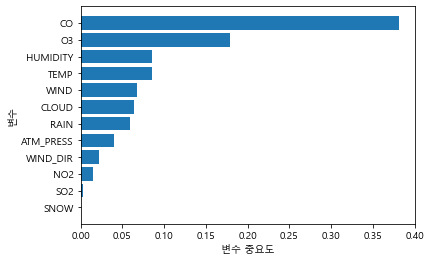

In [60]:
# 설명변수 중요도 그래프
# 중요도가 높은 변수를 상위에 그림
df_importance.sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

### => 잠재적 유의인자 후보 : CO, O3, HUMIDITY, TEMP,  ...

## == Random Forest

In [168]:
# sklearn.ensemble 의 RandomForestRegressor: 예측의사결정나무
from sklearn.ensemble import RandomForestRegressor

#### 기본 옵션으로 분석 

In [169]:
rf_uncustomized = RandomForestRegressor()
rf_uncustomized.fit(df_raw_x, df_raw_y)

# 모델 설명력
print("Score on train set: {:.3f}".format(rf_uncustomized.score(df_raw_x, df_raw_y)))

Score on train set: 0.932


#### 변수 중요도

In [170]:
v_feature_names = df_raw_x.columns
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_names
df_importance["Importance"] = rf_uncustomized.feature_importances_

# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("Importance", ascending=False, inplace = True)
df_importance

,Feature,Importance
2,CO,3.72e-01
0,O3,1.16e-01
4,TEMP,9.03e-02
11,CLOUD,7.26e-02
7,WIND_DIR,6.79e-02
6,WIND,6.40e-02
8,HUMIDITY,6.04e-02
1,NO2,5.71e-02
9,ATM_PRESS,5.09e-02
5,RAIN,3.31e-02


Text(0, 0.5, '변수')

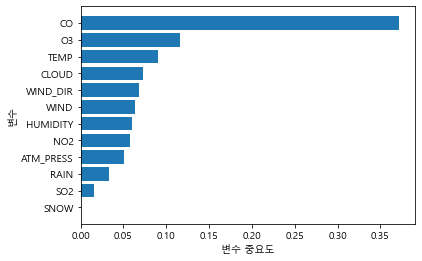

In [171]:
# 설명변수 중요도 그래프
# 중요도가 높은 변수를 상위에 그림
df_importance.sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

### => 잠재적 유의인자 후보 : CO, O3, TEMP, CLOUD, WIND_DIR, ...

## == Gradient Boosting

In [172]:
# sklearn.ensemble 의 GradientBoostingRegressor: 예측그래디언트 부스팅
from sklearn.ensemble import GradientBoostingRegressor

#### 기본 옵션으로 분석 

In [173]:
gb_uncustomized = GradientBoostingRegressor()
gb_uncustomized.fit(df_raw_x, df_raw_y)

# 모델 설명력
print("Score on train set: {:.3f}".format(gb_uncustomized.score(df_raw_x, df_raw_y)))

Score on train set: 0.894


#### 변수 중요도

In [174]:
v_feature_names = df_raw_x.columns
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_names
df_importance["Importance"] = gb_uncustomized.feature_importances_

# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("Importance", ascending=False, inplace = True)
df_importance

,Feature,Importance
2,CO,4.02e-01
0,O3,1.48e-01
4,TEMP,1.13e-01
7,WIND_DIR,6.50e-02
11,CLOUD,6.31e-02
1,NO2,5.14e-02
6,WIND,5.06e-02
8,HUMIDITY,4.28e-02
5,RAIN,3.14e-02
9,ATM_PRESS,2.63e-02


Text(0, 0.5, '변수')

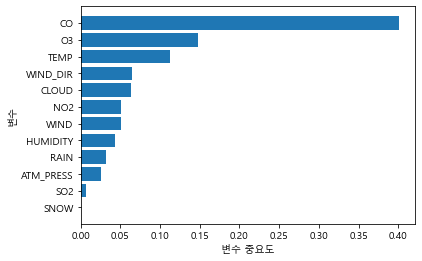

In [175]:
# 설명변수 중요도 그래프
# 중요도가 높은 변수를 상위에 그림
df_importance.sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

### => 잠재적 유의인자 후보 : CO, O3, TEMP, WIND_DIR, CLOUD ...

# @ 영향인자 선정 및 해석 

### 4가지 기법을 활용한 영향인자 선정 

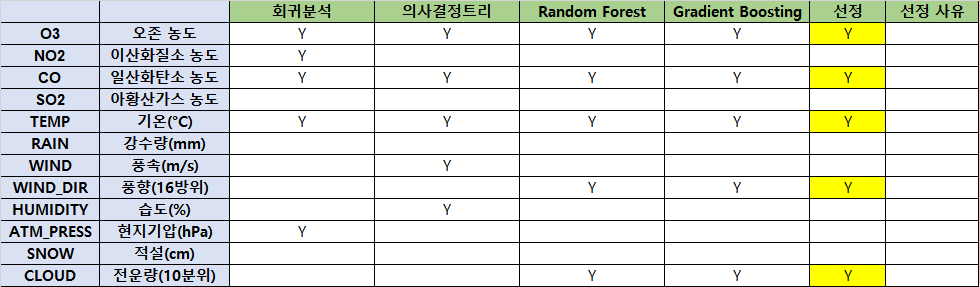

# @예측 모델 개발 및 평가

## 선정된 영향인자 이용한 예측 모델 개발

### 선정된 영향인자 기준으로 설명변수 데이터 재생성 
  회귀분석은 기존 데이터 이용

In [199]:
# 목표변수, 설명변수 데이터 지정
df_anal_y = df_raw["PM10"]

df_anal_x = df_raw[["O3", "CO", "TEMP", "WIND_DIR", "CLOUD"]]

df_anal_x.head()

,O3,CO,TEMP,WIND_DIR,CLOUD
0,0.05,0.5,24.03,249,5.70
1,0.05,0.5,24.29,265,3.83
2,0.04,0.4,24.18,280,6.29
3,0.03,0.4,25.35,263,2.54
4,0.04,0.5,27.30,175,3.92


### 데이터 분할 - 7:3 분할 (분할 비율은 임의로 결정)

    random_state = 1234 로 지정 -> 머신러닝 모델에 사용되는 데이터 동일하게 유지하고 
    동일 데이터를 이용한 모델 간 성능 상호 비교 목적 (각 모델에서는 지정 안함)
     ==> 모델에 입력되는 자료의 선택 순서에 따라 모델 성능이 달라질 수 있음 

In [262]:
# train_test_split(X: 설명변수 데이터, Y: 목표변수 데이터, test_size = test 데이터 비율, random_state: random seed)
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_anal_x, df_anal_y
                                                                , random_state = 1234, test_size = 0.3) 
print("train data X size : {}".format(df_train_x.shape))
print("train data Y size : {}".format(df_train_y.shape))
print("test data X size : {}".format(df_test_x.shape))
print("test data Y size : {}".format(df_test_y.shape))

train data X size : (255, 5)
train data Y size : (255,)
test data X size : (110, 5)
test data Y size : (110,)


## 예측:회귀모델

In [176]:
model_reg = smf.ols("PM10 ~ O3 + CO + TEMP + WIND_DIR + CLOUD", data = df_raw)
model_result = model_reg.fit()
print(model_result.summary())

                            OLS Regression Results                            
Dep. Variable:                   PM10   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.458
Method:                 Least Squares   F-statistic:                     62.59
Date:                Fri, 19 Feb 2021   Prob (F-statistic):           7.97e-47
Time:                        15:36:45   Log-Likelihood:                -1413.6
No. Observations:                 365   AIC:                             2839.
Df Residuals:                     359   BIC:                             2863.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -20.9903      4.820     -4.355      0.0

#### 필요시 유의하지 않은 변수 제외 후 재분석 : CLOUD

In [177]:
model_reg = smf.ols("PM10 ~ O3 + CO + TEMP + WIND_DIR ", data = df_raw)
model_result = model_reg.fit()
print(model_result.summary())

                            OLS Regression Results                            
Dep. Variable:                   PM10   R-squared:                       0.465
Model:                            OLS   Adj. R-squared:                  0.459
Method:                 Least Squares   F-statistic:                     78.34
Date:                Fri, 19 Feb 2021   Prob (F-statistic):           9.47e-48
Time:                        15:38:04   Log-Likelihood:                -1413.7
No. Observations:                 365   AIC:                             2837.
Df Residuals:                     360   BIC:                             2857.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -21.8016      4.515     -4.829      0.0

### => 모델의 설명력은 45.9%, 유의하지 않은 변수(CLOUD) 제외해도 큰 설명력 저하는 없음 

### 다중공선성 확인

In [179]:
df_const = sm.add_constant(df_raw).drop(["PM10","MeasDate"], axis = 1)
# 데이터 테이블 생성 값 입력
df_vif = pd.DataFrame()
# 변수 명 입력
df_vif["variable"] = df_const.columns
# variance_inflation_factor 다중공선성 함수, exog: 설명변수 데이터, exog_idx: 변수 인덱스
df_vif["VIF"] = [variance_inflation_factor(df_const.values, i) for i in range(df_const.shape[1])]
# VIF 낮은 순 정렬
df_vif.sort_values("VIF", inplace = True)
df_vif

,variable,VIF
11,SNOW,1.11
6,RAIN,1.35
8,WIND_DIR,1.50
7,WIND,1.94
4,SO2,1.95
12,CLOUD,2.09
9,HUMIDITY,2.67
1,O3,2.70
3,CO,3.78
5,TEMP,4.60


### => 다중 공선성 문제 없음 -> 예측 결과 사용

## 예측:의사결정나무

#### 기본 옵션으로 트리 생성

In [278]:
tree_uncustomized = DecisionTreeRegressor()
tree_uncustomized.fit(df_train_x, df_train_y)
# Train 데이터 설명력
print("Score on train set: {:.3f}".format(tree_uncustomized.score(df_train_x, df_train_y)))
# test 데이터 설명력
print("Score on test set: {:.3f}".format(tree_uncustomized.score(df_test_x, df_test_y)))

Score on train set: 1.000
Score on test set: 0.029


#### min_samples_leaf: 잎사귀 노드의 최소 자료 수 변경에 따른 모델 성능

In [325]:
# train 및 test 설명력 결과 저장
train_score = []; test_score = [ ]
# min_samples_leaf: 잎사귀 최소 자료 수
para_leaf = [n_leaf * 1 for n_leaf in range(1, 20)]

for v_min_samples_leaf in para_leaf:
    tree = DecisionTreeRegressor(min_samples_leaf=v_min_samples_leaf)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))

# 결과 저장
df_score_leaf = pd.DataFrame()
df_score_leaf["MinSamplesLeaf"] = para_leaf
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score
df_score_leaf

,MinSamplesLeaf,TrainScore,TestScore
0,1,1.00,-0.18
1,2,0.91,0.16
2,3,0.83,0.25
3,4,0.77,0.26
4,5,0.73,0.40
5,6,0.71,0.37
6,7,0.69,0.36
7,8,0.65,0.35
8,9,0.64,0.32
9,10,0.63,0.34


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


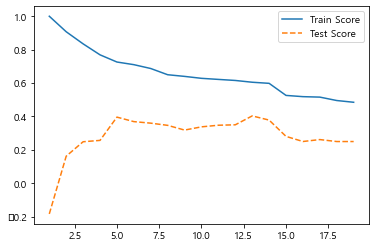

In [326]:
# 모델 설명력 그래프 확인
plt.plot(para_leaf, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_leaf, test_score, linestyle = "--", label = "Test Score")
plt.legend()

##### min_samples_leaf = 5

#### min_samples_split: 분리 노드의 최소 자료 수 변경에 따른 모델 성능

In [327]:
# train 및 test 설명력 결과 저장
train_score = []; test_score = []
# min_samples_split: 분리 노드의 최소 자료 수 
para_split = [n_split * 2 for n_split in range(2, 20)]

for v_min_samples_split in para_split:
    tree = DecisionTreeRegressor(min_samples_leaf=5
                                 , min_samples_split=v_min_samples_split )
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))

# 결과 저장
df_score_split = pd.DataFrame()
df_score_split["MinSamplesSplit"] = para_split
df_score_split["TrainScore"] = train_score
df_score_split["TestScore"] = test_score
# # 모델 설명력 확인
df_score_split

,MinSamplesSplit,TrainScore,TestScore
0,4,0.73,0.40
1,6,0.73,0.40
2,8,0.73,0.40
3,10,0.73,0.40
4,12,0.72,0.38
5,14,0.70,0.33
6,16,0.67,0.35
7,18,0.66,0.36
8,20,0.65,0.39
9,22,0.65,0.38


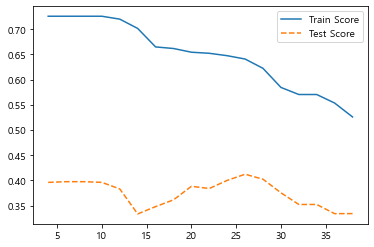

In [328]:
# 모델 설명력 그래프 확인
plt.plot(para_split, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_split, test_score, linestyle = "--", label = "Test Score")
plt.legend()

min_samples_split = 10

#### max_depth: 최대 깊이 변경에 따른 모델 성능

In [329]:
# train 및 test 설명력 결과 저장
train_score = []; test_score = []
# max_depth: 최대 깊이 변경
para_depth = [depth for depth in range(1, 11)]

for v_max_depth in para_depth:
    tree = DecisionTreeRegressor(min_samples_leaf=5, min_samples_split=10
                                  , max_depth = v_max_depth)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_score_depth = pd.DataFrame()
df_score_depth["Depth"] = para_depth
df_score_depth["TrainScore"] = train_score
df_score_depth["TestScore"] = test_score
#  모델 설명력 확인
df_score_depth

,Depth,TrainScore,TestScore
0,1,0.23,0.34
1,2,0.35,0.30
2,3,0.44,0.37
3,4,0.56,0.36
4,5,0.62,0.38
5,6,0.68,0.37
6,7,0.69,0.38
7,8,0.71,0.38
8,9,0.73,0.40
9,10,0.73,0.40


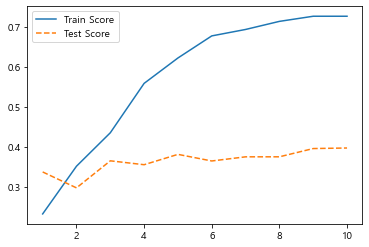

In [330]:
# 모델 설명력 그래프 확인
plt.plot(para_depth, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_depth, test_score, linestyle = "--", label = "Test Score")
plt.legend()

max_depth = 7

In [332]:
# 최종 모델 성능 평가
tree_final = DecisionTreeRegressor(min_samples_leaf = 5, min_samples_split = 10, max_depth = 7 )
tree_final.fit(df_train_x, df_train_y)

# 모델 평가 : Train 데이터
print("Score on train set: {:.3f}".format(tree_final.score(df_train_x, df_train_y)))
# 모델 평가 : Test 데이터 
print("Score on test set: {:.3f}".format(tree_final.score(df_test_x, df_test_y)))

Score on train set: 0.693
Score on test set: 0.374


### 설명변수의 중요도

In [286]:
v_feature_names = df_train_x.columns
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_names
df_importance["Importance"] = tree_final.feature_importances_

# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("Importance", ascending=False, inplace = True)
df_importance

,Feature,Importance
1,CO,0.44
0,O3,0.18
4,CLOUD,0.17
2,TEMP,0.16
3,WIND_DIR,0.05


Text(0, 0.5, '변수')

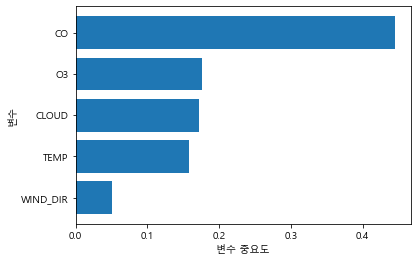

In [287]:
# 설명변수 중요도 그래프
# 중요도가 높은 변수를 상위에 그림
df_importance.sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

## 예측:Random Forest

#### 기본 옵션으로 트리 생성

In [333]:
rf_uncustomized = RandomForestRegressor()
rf_uncustomized.fit(df_train_x, df_train_y)
# Train 데이터 설명력
print("Score on train set: {:.3f}".format(rf_uncustomized.score(df_train_x, df_train_y)))
# Test 데이터 설명력
print("Score on test set: {:.3f}".format(rf_uncustomized.score(df_test_x, df_test_y)))

Score on train set: 0.917
Score on test set: 0.477


n_estimators: 트리의 수 변경에 따른 모델 성능

In [336]:
# train 및 test 설명력 결과 저장
train_score = []; test_score = []
# n_estimatos: 트리 수 변경: 1~100
para_n_tree = [n_tree * 10 for n_tree in range(1, 11)]

for v_n_estimators in para_n_tree:
    rf = RandomForestRegressor(n_estimators = v_n_estimators)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))

# 결과 저장
df_score_n = pd.DataFrame()
df_score_n["n_estimators"] = para_n_tree
df_score_n["TrainScore"] = train_score
df_score_n["TestScore"] = test_score
# 모델 설명력 확인
df_score_n

,n_estimators,TrainScore,TestScore
0,10,0.90,0.45
1,20,0.90,0.45
2,30,0.91,0.47
3,40,0.92,0.48
4,50,0.92,0.47
5,60,0.92,0.46
6,70,0.92,0.47
7,80,0.92,0.48
8,90,0.92,0.46
9,100,0.92,0.50


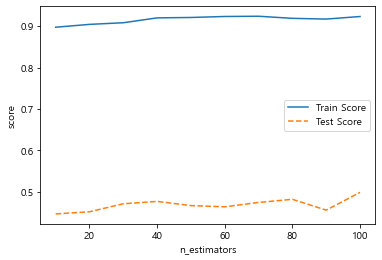

In [337]:
# 모델 설명력 그래프 확인
plt.plot(para_n_tree, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_n_tree, test_score, linestyle = "--", label = "Test Score")
plt.ylabel("score"); plt.xlabel("n_estimators")
plt.legend()

##### n_estimators = 100

#### min_samples_leaf: 잎사귀 노드의 최소 자료 수 변경에 따른 모델 성능

In [338]:
# train 및 test 설명력 결과 저장
train_score = []; test_score = []
# min_samples_leaf: 잎사귀 최소 자료 수 
para_leaf = [n_leaf * 1 for n_leaf in range(1, 21)]

for v_min_samples_leaf in para_leaf:
    rf = RandomForestRegressor( n_estimators = 100,
                                min_samples_leaf = v_min_samples_leaf)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_score_leaf = pd.DataFrame()
df_score_leaf["MinSamplesLeaf"] = para_leaf
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score

# 모델 설명력 확인
df_score_leaf

,MinSamplesLeaf,TrainScore,TestScore
0,1,0.92,0.48
1,2,0.86,0.49
2,3,0.80,0.48
3,4,0.76,0.48
4,5,0.72,0.47
5,6,0.68,0.44
6,7,0.66,0.45
7,8,0.64,0.43
8,9,0.62,0.43
9,10,0.60,0.42


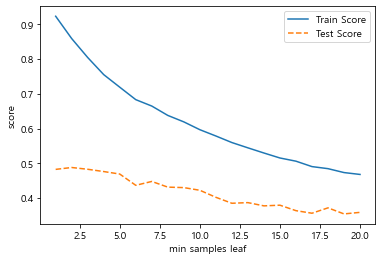

In [340]:
# 모델 설명력 그래프 확인
plt.plot(para_leaf, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_leaf, test_score, linestyle = "--", label = "Test Score")
plt.ylabel("score"); plt.xlabel("min samples leaf")
plt.legend()

min_samples_leaf = 5

#### min_samples_split: 분리 노드의 최소 자료 수 변경에 따른 모델 성능

In [341]:
# train 및 test 설명력 결과 저장
train_score = []; test_score = []
# min_samples_split: 분할하기 위한 노드의 최소 자료 수 
para_split = [n_split * 2 for n_split in range(2, 11)]

for v_min_samples_split in para_split:
    rf = RandomForestRegressor(n_estimators = 100, min_samples_leaf = 5,
                               min_samples_split = v_min_samples_split)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_score_split = pd.DataFrame()
df_score_split["MinSamplesSplit"] = para_split
df_score_split["TrainScore"] = train_score
df_score_split["TestScore"] = test_score
# 모델 설명력 확인
df_score_split

,MinSamplesSplit,TrainScore,TestScore
0,4,0.72,0.46
1,6,0.72,0.46
2,8,0.72,0.47
3,10,0.72,0.46
4,12,0.70,0.47
5,14,0.68,0.45
6,16,0.67,0.47
7,18,0.66,0.45
8,20,0.65,0.45


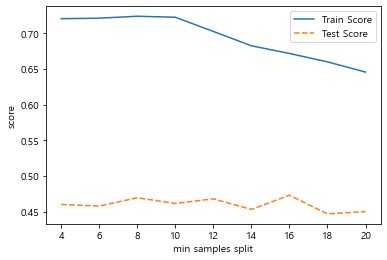

In [342]:
# 모델 설명력 그래프 확인
plt.plot(para_split, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_split, test_score, linestyle = "--", label = "Test Score")
plt.ylabel("score"); plt.xlabel("min samples split")
plt.legend()

min_samples_split = 8

#### max_depth: 최대 깊이 변경에 따른 모델 성능

In [343]:
# train 및 test 설명력 결과 저장
train_score = []; test_score = []
# max_depth: 최대 깊이 변경
para_depth = [depth for depth in range(1, 11)]

for v_max_depth in para_depth:
    rf = RandomForestRegressor(n_estimators = 100, 
                               min_samples_leaf = 5, min_samples_split = 8,
                               max_depth = v_max_depth)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_score_depth = pd.DataFrame()
df_score_depth["Depth"] = para_depth
df_score_depth["TrainScore"] = train_score
df_score_depth["TestScore"] = test_score
# 모델 설명력 확인
df_score_depth

,Depth,TrainScore,TestScore
0,1,0.25,0.34
1,2,0.40,0.35
2,3,0.51,0.44
3,4,0.60,0.46
4,5,0.67,0.47
5,6,0.70,0.47
6,7,0.72,0.47
7,8,0.72,0.45
8,9,0.72,0.46
9,10,0.72,0.45


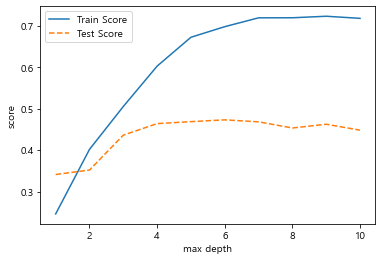

In [344]:
# 모델 설명력 그래프 확인
plt.plot(para_depth, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_depth, test_score, linestyle = "--", label = "Test Score")
plt.ylabel("score"); plt.xlabel("max depth")
plt.legend()

max_depth = 5

### 최종 모델

In [345]:
# 최종 모델 성능 평가
rf_final = RandomForestRegressor(n_estimators = 100, min_samples_leaf = 5,
                                 min_samples_split = 8, max_depth = 5)
rf_final.fit(df_train_x, df_train_y)

# 탐색분석을 통한 DT 최적 조건 도출
tree_final = DecisionTreeRegressor(min_samples_leaf = 5, min_samples_split = 10, max_depth = 7 )
tree_final.fit(df_train_x, df_train_y)

# 모델 평가 : Train 데이터
print("Score on train set: {:.3f}".format(tree_final.score(df_train_x, df_train_y)))
# 모델 평가 : Test 데이터 
print("Score on test set: {:.3f}".format(tree_final.score(df_test_x, df_test_y)))

Score on train set: 0.693
Score on test set: 0.374


#### 변수 중요도

In [230]:
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_names
df_importance["Importance"] = rf_final.feature_importances_

# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("Importance", ascending=False, inplace = True)
df_importance

,Feature,Importance
1,CO,0.56
0,O3,0.15
2,TEMP,0.12
4,CLOUD,0.09
3,WIND_DIR,0.08


Text(0, 0.5, '변수')

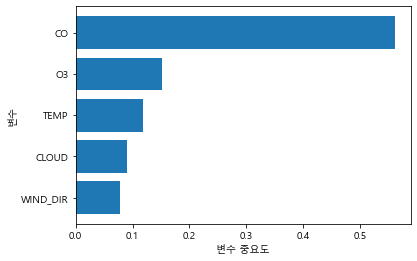

In [231]:
# 설명변수 중요도 그래프
# 중요도가 높은 변수를 상위에 그림
df_importance.sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

## 예측:Gradient Boosting

#### 기본 옵션으로 트리 생성

In [346]:
# 모델 생성: GradientBoostingRegressor
# gb_uncustomized = GradientBoostingRegressor(random_state=1234)
gb_uncustomized = GradientBoostingRegressor()
gb_uncustomized.fit(df_train_x, df_train_y)
# Train 데이터 설명력
print("Score on train set: {:.3f}".format(gb_uncustomized.score (df_train_x, df_train_y)))
# Test 데이터 설명력
print("Score on test set: {:.3f}".format(gb_uncustomized.score (df_test_x, df_test_y)))

Score on train set: 0.892
Score on test set: 0.503


#### n_estimators: 트리의 수 변경에 따른 모델 성능

In [349]:
# train 및 test 설명력 결과 저장
train_score = []; test_score = []
# n_estimatos: 트리 수 변경(10~100)
para_n_tree = [n_tree * 10 for n_tree in range(1, 16)]

for v_n_estimators in para_n_tree:
    gb = GradientBoostingRegressor(n_estimators = v_n_estimators)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))

# 결과 저장
df_score_n = pd.DataFrame()
df_score_n["Estimators"] = para_n_tree
df_score_n["TrainScore"] = train_score
df_score_n["TestScore"] = test_score
# 모델 설명력 확인
df_score_n

,Estimators,TrainScore,TestScore
0,10,0.47,0.41
1,20,0.64,0.48
2,30,0.72,0.49
3,40,0.76,0.50
4,50,0.79,0.51
5,60,0.82,0.50
6,70,0.85,0.51
7,80,0.87,0.49
8,90,0.88,0.50
9,100,0.89,0.50


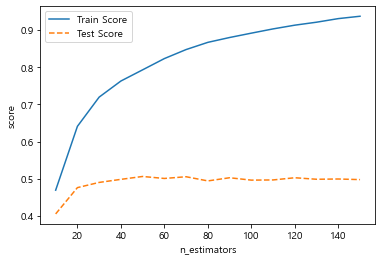

In [350]:
# 모델 설명력 그래프 확인
plt.plot(para_n_tree, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_n_tree, test_score, linestyle = "--", label = "Test Score")
plt.ylabel("score"); plt.xlabel("n_estimators")
plt.legend()

##### n_estimators = 100

#### min_samples_leaf: 잎사귀 노드의 자료 수 지정

In [351]:
# train 및 test 설명력 결과 저장
train_score = []; test_score = []
# min_samples_leaf: 잎사귀 최소 자료 수 
para_leaf = [n_leaf * 1 for n_leaf in range(1, 11)]

for v_min_samples_leaf in para_leaf:
    rf = GradientBoostingRegressor(n_estimators = 100,
                                   min_samples_leaf = v_min_samples_leaf)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))

# 결과 저장
df_score_leaf = pd.DataFrame()
df_score_leaf["MinSamplesLeaf"] = para_leaf
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score
# 모델 설명력 확인
df_score_leaf

,MinSamplesLeaf,TrainScore,TestScore
0,1,0.89,0.50
1,2,0.87,0.49
2,3,0.87,0.49
3,4,0.85,0.49
4,5,0.84,0.49
5,6,0.83,0.48
6,7,0.83,0.50
7,8,0.83,0.48
8,9,0.82,0.47
9,10,0.82,0.45


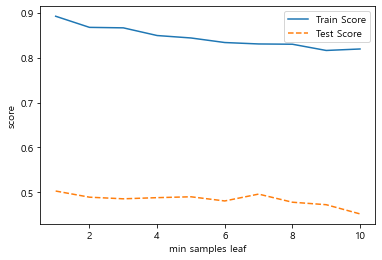

In [352]:
# 모델 설명력 그래프 확인
plt.plot(para_leaf, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_leaf, test_score, linestyle = "--", label = "Test Score")
plt.ylabel("score"); plt.xlabel("min samples leaf")
plt.legend()

min_samples_leaf = 7

#### min_samples_split: 분할하기 위한 노드의 최소 자료 수

In [353]:
# train 및 test 설명력 결과 저장
train_score = []; test_score = []
# min_samples_split: 분할하기 위한 노드의 최소 자료 수 
para_split = [n_split * 2 for n_split in range(1, 11)]

for v_min_samples_split in para_split:
    gb = GradientBoostingRegressor(n_estimators = 100, min_samples_leaf = 7,
                                   min_samples_split = v_min_samples_split)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))

# 결과 저장
df_score_split = pd.DataFrame()
df_score_split["MinSamplesSplit"] = para_split
df_score_split["TrainScore"] = train_score
df_score_split["TestScore"] = test_score
# 모델 설명력 확인
df_score_split

,MinSamplesSplit,TrainScore,TestScore
0,2,0.83,0.50
1,4,0.83,0.50
2,6,0.83,0.50
3,8,0.83,0.50
4,10,0.83,0.50
5,12,0.83,0.50
6,14,0.83,0.50
7,16,0.83,0.48
8,18,0.82,0.48
9,20,0.82,0.49


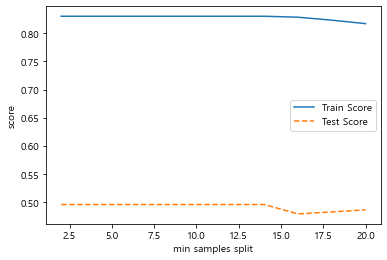

In [354]:
# 모델 설명력 그래프 확인 : 22개
plt.plot(para_split, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_split, test_score, linestyle = "--", label = "Test Score")
plt.ylabel("score"); plt.xlabel("min samples split")
plt.legend()

min_samples_split = 13

#### max_depth: 최대 깊이 변경에 따른 설명력 변화

In [355]:
# train 및 test 설명력 결과 저장
train_score = []; test_score = []
# max_depth: 최대 깊이 변경
para_depth = [depth for depth in range(1, 11)]

for v_max_depth in para_depth:
    gb = GradientBoostingRegressor(n_estimators = 100, min_samples_leaf = 7,
                                   min_samples_split = 13, max_depth = v_max_depth)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))

# 결과 저장
df_score_depth = pd.DataFrame()
df_score_depth["Depth"] = para_depth
df_score_depth["TrainScore"] = train_score
df_score_depth["TestScore"] = test_score
# 모델 설명력 확인
df_score_depth

,Depth,TrainScore,TestScore
0,1,0.53,0.43
1,2,0.73,0.47
2,3,0.83,0.50
3,4,0.90,0.46
4,5,0.94,0.48
5,6,0.96,0.47
6,7,0.97,0.47
7,8,0.98,0.46
8,9,0.98,0.47
9,10,0.99,0.46


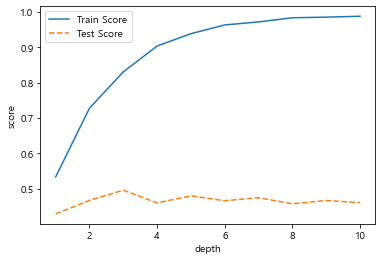

In [356]:
# 모델 설명력 그래프 확인 : 4개
plt.plot(para_depth, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_depth, test_score, linestyle = "--", label = "Test Score")
plt.ylabel("score"); plt.xlabel("depth")
plt.legend()

max_depth = 7

In [357]:
# train 및 test 설명력 결과 저장
train_score = []; test_score = []
# learning rate: 학습률 변경 0.1 ~ 0.9
para_lr = [lr * 0.1 for lr in range(1, 10)]

for v_learning_rate in para_lr:
    gb = GradientBoostingRegressor( n_estimators = 100, min_samples_leaf = 7,
		                   min_samples_split = 13, max_depth = 7, learning_rate = v_learning_rate)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))

# 결과 저장
df_score_lr = pd.DataFrame()
df_score_lr["LearningRate"] = para_lr
df_score_lr["TrainScore"] = train_score
df_score_lr["TestScore"] = test_score
# 모델 설명력 확인
df_score_lr

,LearningRate,TrainScore,TestScore
0,0.1,0.98,0.46
1,0.2,1.00,0.44
2,0.3,1.00,0.42
3,0.4,1.00,0.40
4,0.5,1.00,0.38
5,0.6,1.00,0.32
6,0.7,1.00,0.38
7,0.8,1.00,0.30
8,0.9,1.00,0.21


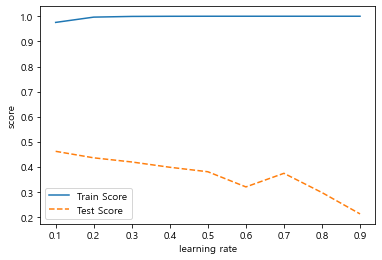

In [358]:
# 모델 설명력 그래프 확인
plt.plot(para_lr, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_lr, test_score, linestyle = "--", label = "Test Score")
plt.ylabel("score"); plt.xlabel("learning rate")
plt.legend()

learning_rate = 0.1

### 최종 모델 생성

In [359]:
gb_final = GradientBoostingRegressor( n_estimators = 100, min_samples_leaf = 7,
                                     min_samples_split = 13, max_depth = 7, learning_rate = 0.1)
gb_final.fit(df_train_x, df_train_y)

# Train 데이터 설명력
print("Score on train set: {:.3f}".format(gb_final.score(df_train_x, df_train_y)))
# Test 데이터 설명력
print("Score on test set: {:.3f}".format(gb_final.score(df_test_x, df_test_y)))


Score on train set: 0.975
Score on test set: 0.463


#### 변수 중요도

In [248]:
# 변수명 저장
v_feature_names = df_train_x.columns

# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_names
df_importance["Importance"] = gb_final.feature_importances_

# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("Importance", ascending=False, inplace = True)
df_importance

,Feature,Importance
1,CO,0.41
2,TEMP,0.19
0,O3,0.16
4,CLOUD,0.14
3,WIND_DIR,0.11


Text(0, 0.5, '변수')

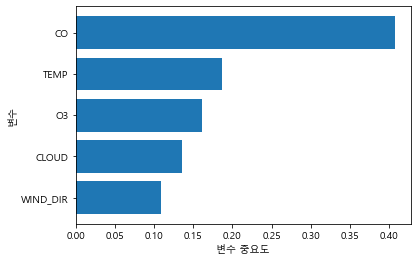

In [249]:
# 설명변수 중요도 그래프
# 중요도가 높은 변수를 상위에 그림. 
df_importance.sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

## 예측모델 통합 평가

### 최종 선정된 모델 

In [363]:
# 회귀 모델 : (주의-아래 모델과 사용하는 데이터가 다름)
reg_model = smf.ols("PM10 ~ O3 + CO + TEMP + WIND_DIR ", data = df_raw)
reg_result = reg_model.fit()

# Decision Tree
dt_model = DecisionTreeRegressor(min_samples_leaf = 5, min_samples_split = 10, max_depth = 7 )
dt_model.fit(df_train_x, df_train_y)

# Random Forest
rf_model = RandomForestRegressor(n_estimators = 100, min_samples_leaf = 5,
                                 min_samples_split = 8, max_depth = 5)
rf_model.fit(df_train_x, df_train_y)

# Gradient Boosting
gb_model = GradientBoostingRegressor( n_estimators = 100, min_samples_leaf = 7,
                                     min_samples_split = 13, max_depth = 7, learning_rate = 0.1)
gb_model.fit(df_train_x, df_train_y)


GradientBoostingRegressor(max_depth=7, min_samples_leaf=7, min_samples_split=13)

In [369]:
# 모델 리스트 생성
models = ["회귀분석", "의사결정나무", "랜덤 포레스트", "그래디언트 부스팅"]
# 평가 리스트 초기화
r2, mse, mae, mape = [],[],[],[]

In [370]:
# 예측 및 성능 평가:선형 회귀
reg_y_pred = reg_result.predict(df_test_x)

# 평가
r2.append(r2_score(df_test_y, reg_y_pred))
mse.append(mean_squared_error(df_test_y, reg_y_pred))
mae.append(mean_absolute_error(df_test_y, reg_y_pred))
mape.append(mean_absolute_percentage_error(df_test_y, reg_y_pred))

In [371]:
# 예측 및 성능 평가:의사결정나무
dt_y_pred = dt_model.predict(df_test_x)

# 평가
r2.append(r2_score(df_test_y, dt_y_pred))
mse.append(mean_squared_error(df_test_y, dt_y_pred))
mae.append(mean_absolute_error(df_test_y, dt_y_pred))
mape.append(mean_absolute_percentage_error(df_test_y, dt_y_pred))

In [372]:
# 예측 및 성능 평가:Random Forest
rf_y_pred = rf_model.predict(df_test_x)

# 평가
r2.append(r2_score(df_test_y, rf_y_pred))
mse.append(mean_squared_error(df_test_y, rf_y_pred))
mae.append(mean_absolute_error(df_test_y, rf_y_pred))
mape.append(mean_absolute_percentage_error(df_test_y, rf_y_pred))

In [373]:
# 예측 및 성능 평가:Gradient Boosting
gb_y_pred = gb_model.predict(df_test_x)

# 평가
r2.append(r2_score(df_test_y, gb_y_pred))
mse.append(mean_squared_error(df_test_y, gb_y_pred))
mae.append(mean_absolute_error(df_test_y, gb_y_pred))
mape.append(mean_absolute_percentage_error(df_test_y, gb_y_pred))

In [374]:
r2

[0.4667920234439723,
 0.3754348793824487,
 0.46495952537442564,
 0.46256388252398783]

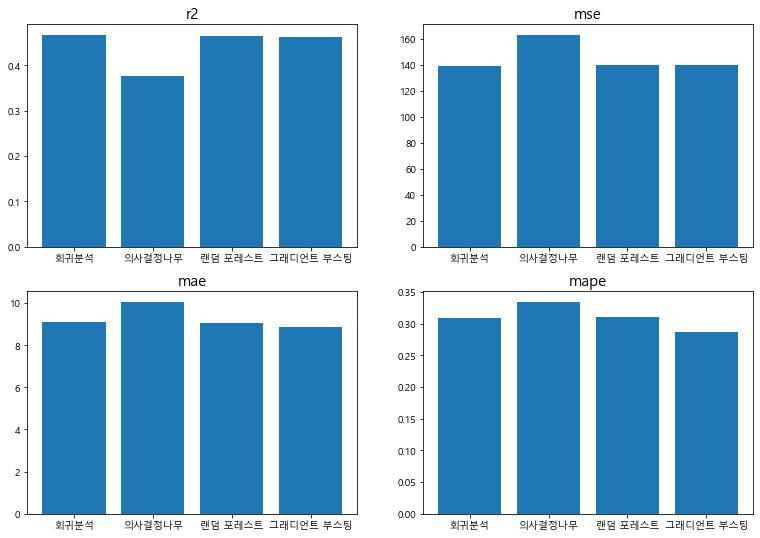

In [375]:
fig, ax = plt.subplots(2,2, figsize = (13,9))
ax[0, 0].bar(models, r2)
ax[0, 0].set_title("r2").set_fontsize(15)

ax[0, 1].bar(models, mse)
ax[0, 1].set_title("mse").set_fontsize(15)

ax[1, 0].bar(models, mae)
ax[1, 0].set_title("mae").set_fontsize(15)

ax[1, 1].bar(models, mape)
ax[1, 1].set_title("mape").set_fontsize(15)

### => 전반적으로 모델의 예측력이 미흡 -> 변수 파생 등의 과정을 통해 모델 개선작업 필요

    의사결정나무 : r2 기준으로는 타 모델보다 성능이 떨어지지만 MAPE 등 다른 지표 기준으로는 성능이 좋음

# 모델 종합 평가 및 예측 결과 해석

### 의사결정나무 기준으로 개선안 탐색 및 정리

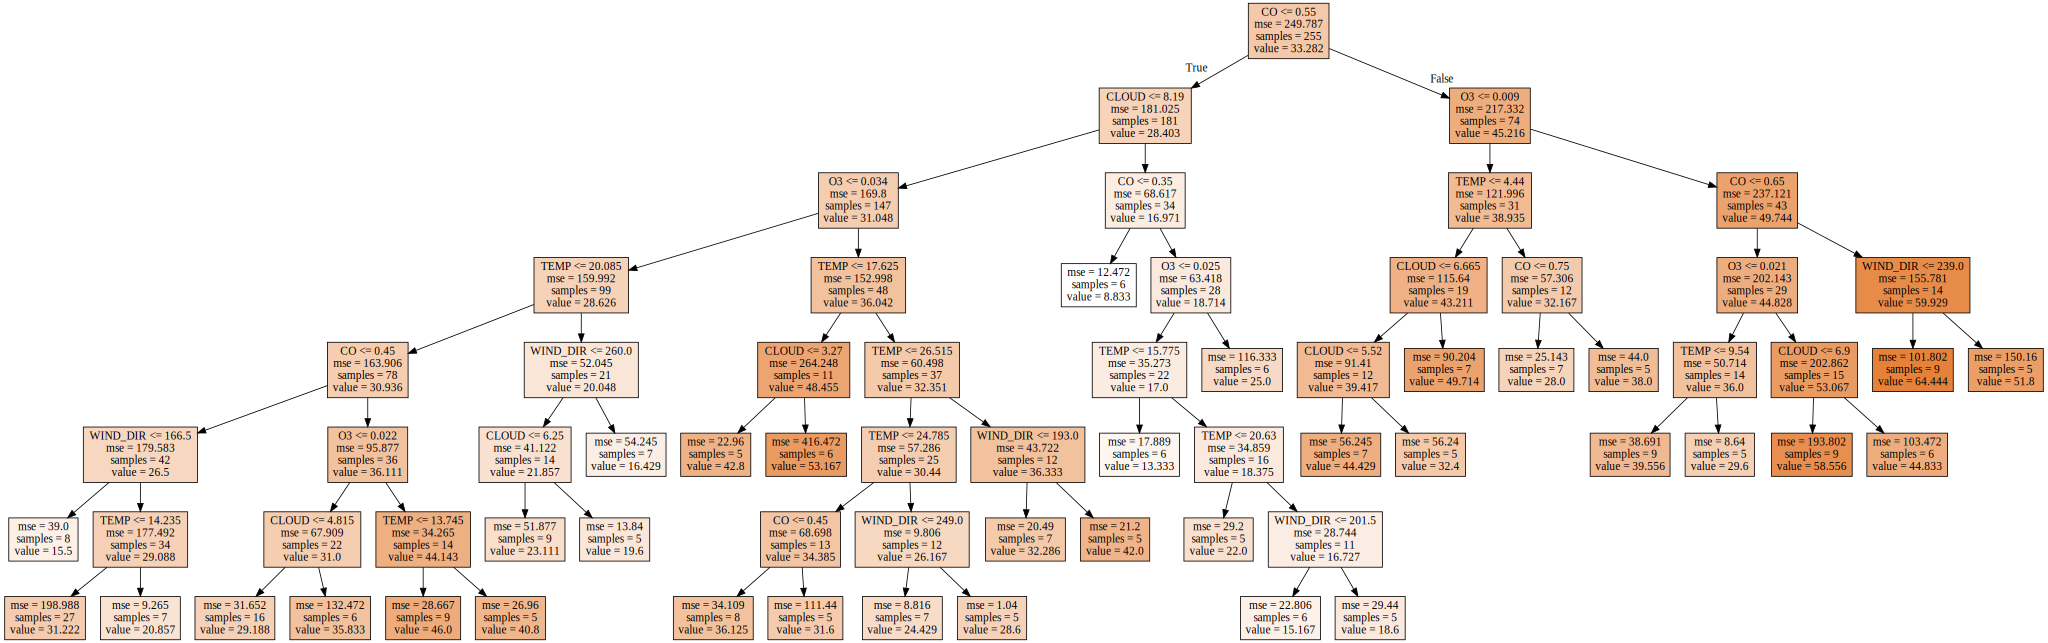

In [376]:
# 변수명 저장
v_feature_name = df_train_x.columns

# 최종 모델 : dt_model
dt_model.fit(df_train_x, df_train_y)

export_graphviz(tree_final, out_file="tree_final.dot",
                feature_names = v_feature_name, impurity = True, filled = True)

with open("tree_final.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

# 개선안 도출

## => 미세먼지 발생은 xxxxx....